In [1]:
# Imports and initial setup

from copy import deepcopy
from itertools import combinations, product
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
from deap import base, creator
from scipy.stats import mannwhitneyu

import pylot.search_config as cfg
from src.utils.PairwiseDistance import PairwiseDistance

# Set up matplotlib.
plt.style.use('bmh')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

# Create fitness and individual datatypes.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin,
                safety_req_value=float)
creator.create("Scenario", creator.Individual)
creator.create("OutputMLC", creator.Individual)

# Set up the postprocess parameters.
# The path to the postprocess results directory.
RESULTS_DIR = Path.cwd().joinpath('results').joinpath('postprocess')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Set the values of fitness and distance thresholds.
FITNESS_THRESHOLDS = [0.05, 0.1, 0.15, 0.2, 0.25]
DISTANCE_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Set the number of intervals.
NUM_INTERVALS = 10


c:\Users\sepeh\Projects\MLCSHE\venv1\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# RQ1: Effectiveness

## Load and Process Data

### Read Input Files

*NOTE: Only read new files when the input files have changed. Otherwise, load the saved raw or processed data*

In [2]:
def read_files(files: list) -> dict:
    """Reads the files listed in `files` and returns a dictionary of
    the form `{run_number: [fitness values]}`.
    """
    results_dict = {}
    for run_number, file in enumerate(files, 1):
        with open(file, 'rb') as f:
            cs_archive = pickle.load(f)

        results_dict[f'run_{run_number}'] = cs_archive

    return results_dict

# Import the results.
search_methods = ['MLCSHE', 'RS', 'GA']

mlcshe_results = [
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221002_184723_CCEA_Pylot\20221002_184723_CCEA_Pylot\20221002_184724_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221005_220401_CCEA_Pylot\20221005_220401_CCEA_Pylot\20221005_220401_cs_archive_pickle.log',
    # r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221009_230946_CCEA_Pylot\20221009_230946_CCEA_Pylot\20221009_230946_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221208_172525_CCEA_Pylot\20221208_172525_CCEA_Pylot\20221208_172525_cs_archive_pickle.log',
    # r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221012_203758_CCEA_Pylot\20221012_203758_CCEA_Pylot\20221012_203758_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221211_214951_CCEA_Pylot\20221211_214951_CCEA_Pylot\20221211_214951_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221016_234557_CCEA_Pylot\20221016_234557_CCEA_Pylot\20221016_234557_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221020_203533_CCEA_Pylot\20221020_203533_CCEA_Pylot\20221020_203533_cs_archive_pickle.log',
    # r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221024_144711_CCEA_Pylot\20221024_144711_CCEA_Pylot\20221024_144711_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221214_153433_CCEA_Pylot\20221214_153433_CCEA_Pylot\20221214_153434_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221027_162715_CCEA_Pylot\20221027_162715_CCEA_Pylot\20221027_162715_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221101_211509_CCEA_Pylot\20221101_211509_CCEA_Pylot\20221101_211509_cs_archive_pickle.log',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_MLCSHE_Results\20221104_191808_CCEA_Pylot\20221104_191808_CCEA_Pylot\20221104_191808_cs_archive_pickle.log'
]

rs_results = [
    # r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20220926_010645_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221003_090030_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221005_203358_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221008_121823_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221010_214517_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221016_191947_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221019_093933_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221025_082242_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221027_191843_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221104_093109_RS_Pylot\_RS_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_RS_Results\20221107_070910_RS_Pylot\_RS_cs.pkl'
]

ga_results = [
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221209_211827_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221211_164637_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221214_212238_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221218_010401_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221223_010639_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221226_092531_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221228_015403_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20221230_130624_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20230101_173513_GA_Pylot\_GA_cs.pkl',
    r'C:\Users\sepeh\Projects\MLCSHE\results\Pylot_GA_Results\20230104_190326_GA_Pylot\_GA_cs.pkl'
]

raw_results_list = [mlcshe_results, rs_results, ga_results]

raw_results_dict = {method:read_files(result) for method, result in zip(search_methods, raw_results_list)}

# Save the raw results to a file.
raw_results_file = RESULTS_DIR.joinpath('raw_results.pkl')
with open(raw_results_file, 'wb') as f:
    pickle.dump(raw_results_dict, f)

### Process Raw Data & Calculate Metrics

In [7]:
def remove_similar(cs_archive: list, min_distance: 0.0) -> list:
    """Remove similar complete solutions from `cs_archive` based on
    their pairwise distance.
    """
    # Compute pairwise distance between all complete solutions solutions.
    pdist = PairwiseDistance(
        cs_archive, cfg.numeric_ranges, cfg.categorical_indices)

    # If a member of the cs_archive is not similar to any other member in the cs_archive_distinct
    # list, then add it to the cs_archive_distinct list.
    # The first member of the cs_archive_distinct is the member of cs_archive with the lowest fitness.
    cs_archive_distinct = []
    if len(cs_archive) > 1:
        # cs_archive_distinct = [cs_archive[0]]
        for cs in cs_archive:
            if not any([pdist.get_distance(cs, cs_distinct) < min_distance for cs_distinct in cs_archive_distinct]):
                cs_archive_distinct.append(cs)
    else:
        cs_archive_distinct = cs_archive
    

    return cs_archive_distinct


def sort_trim(cs_archive: list, max_fitness: float) -> list:
    """Sort and trim the `cs_archive` based on the `max_fitness` value.
    """
    # Sort the cs_archive from low to high fitness.
    cs_archive_sorted = sorted(
        cs_archive, key=lambda x: x.fitness.values[0])

    # Trim the cs archive
    for cs in cs_archive_sorted:
        if cs.fitness.values[0] > max_fitness:
            cs_archive_trimmed = cs_archive_sorted[:cs_archive_sorted.index(
                cs)]
            break

    return cs_archive_trimmed

def process_results(results: dict, max_fitness: float = 1.0, min_distance: float = 0.0, verbose: bool = False) -> dict:
    """Gets a `results` dict and returns a list of distinct
    complete solutions that have fitness values higher than
    `max_fitness` and pairwise distance higher than `min_distance`.
    """
    distinct_trimmed_fitness_dict = {}
    for run_number, cs_archive in results.items():
        # Sort and trim the cs_archive based on the `max_fitness` value.
        boundaries = sort_trim(cs_archive, max_fitness)
        # Remove similar complete solutions from `cs_archive` based on `min_distance`.
        distinct_boundaries = remove_similar(boundaries, min_distance)

        if verbose:
            print(f'len(cs_archive) = {len(cs_archive)}')
            print(f'len(boundaries) = {len(boundaries)}')
            print(f'propotion = {len(boundaries) / len(cs_archive)}')
            print(f'len(distinct_boundaries) = {len(distinct_boundaries)}')

        distinct_trimmed_fitness_dict[run_number] = [cs.fitness.values[0]
                                                     for cs in distinct_boundaries]

    return distinct_trimmed_fitness_dict

In [8]:
# Load the raw results from a file.
raw_results_file = RESULTS_DIR.joinpath('raw_results.pkl')
with open(raw_results_file, 'rb') as f:
    raw_results_dict = pickle.load(f)

processed_results_df_rq1 = pd.DataFrame()
# process the results
for method, mf, mb in product(list(raw_results_dict.keys()), FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS):
    processed_results_df_rq1 = pd.concat([processed_results_df_rq1, pd.DataFrame([{'method': method, 'fit_thr':mf, 'dist_thr':mb, 'results':process_results(raw_results_dict[method], max_fitness=mf, min_distance=mb), 'n_runs':len(raw_results_dict[method])}])])
processed_results_df_rq1.reset_index(drop=True, inplace=True)

# Save the processed results to a file.
processed_results_file_rq1 = RESULTS_DIR.joinpath('processed_results_rq1.pkl')
with open(processed_results_file_rq1, 'wb') as f:
    pd.to_pickle(processed_results_df_rq1, f)

In [9]:
# Load processed_results_df_rq1
processed_results_file_rq1 = RESULTS_DIR.joinpath('processed_results_rq1.pkl')
with open(processed_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

def calculate_dbs(data: dict):
    return [len(fitness_values) for fitness_values in list(data.values())]

def calculate_afv(data: dict):
    # return [np.mean(fitness_values) if np.mean(fitness_values) > 0 else 0.0 for fitness_values in list(data.values())]
    return [np.mean(fitness_values) for fitness_values in list(data.values())]

# Calculate and add DBS and AFV values to the processed_results_df_rq1
processed_results_df_rq1['dbs'] = processed_results_df_rq1['results'].apply(lambda x: calculate_dbs(x))
processed_results_df_rq1['dbs_mean'] = processed_results_df_rq1['dbs'].apply(lambda x: np.mean(x))
processed_results_df_rq1['dbs_std'] = processed_results_df_rq1['dbs'].apply(lambda x: np.std(x))
processed_results_df_rq1['dbs_95_ci'] = 1.96 * processed_results_df_rq1['dbs_std'] / np.sqrt(processed_results_df_rq1['n_runs'])
processed_results_df_rq1['afv'] = processed_results_df_rq1['results'].apply(lambda x: calculate_afv(x))
processed_results_df_rq1['afv_mean'] = processed_results_df_rq1['afv'].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan)
processed_results_df_rq1['afv_std'] = processed_results_df_rq1['afv'].apply(lambda x: np.std(x))
processed_results_df_rq1['afv_95_ci'] = 1.96 * processed_results_df_rq1['afv_std'] / np.sqrt(processed_results_df_rq1['n_runs'])
# change Nan values to 0
processed_results_df_rq1.fillna(0, inplace=True)

# Save the processed results to a file.
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'wb') as f:
    pd.to_pickle(processed_results_df_rq1, f)

c:\Users\sepeh\Projects\MLCSHE\venv1\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sepeh\AppData\Local\Temp\ipykernel_23428\760806958.py:19: RuntimeWarning: Mean of empty slice
  processed_results_df_rq1['afv_mean'] = processed_results_df_rq1['afv'].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan)


In [10]:
# Load calculated_results_df_rq1_5mod
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)
processed_results_df_rq1[(processed_results_df_rq1.method=='GA') & (processed_results_df_rq1.dist_thr==0.4)].reindex(columns=['method', 'fit_thr', 'dbs_mean', 'dbs_95_ci', 'afv_mean', 'afv_95_ci'])
# processed_results_df_rq1[processed_results_df_rq1.method=='GA'].reindex(columns=['method', 'fit_thr', 'dist_thr', 'dbs_mean', 'dbs_95_ci', 'afv_mean', 'afv_95_ci'])
# processed_results_df_rq1

,method,fit_thr,dbs_mean,dbs_95_ci,afv_mean,afv_95_ci
93,GA,0.05,1.7,0.396870,0.028350,0.003709
102,GA,0.10,3.1,0.584724,0.046876,0.005182
111,GA,0.15,4.4,0.411133,0.069619,0.007367
120,GA,0.20,4.9,0.514850,0.078106,0.010822
129,GA,0.25,5.3,0.484084,0.089879,0.010507


In [ ]:
# Load calculated_results_file_rq1
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    calculated_results_df_rq1 = pd.read_pickle(f)

# print the average dbs and afv values for each index, i.e., each method, fitness threshold, and distance threshold
print(f'method\tfit_thr\tdist_thr\tdbs_mean\tdbs_95_ci\tafvb_mean\tafv_95_ci')
for i, row in calculated_results_df_rq1.iterrows():
    print(f'{row["method"]}\t{row["fit_thr"]}\t{row["dist_thr"]}\t{row["dbs_mean"]}\t{row["dbs_95_ci"]}\t{row["afv_mean"]}\t{row["afv_95_ci"]}')

## Statistical Tests of $DBS$ and $AFV$ Values

In [11]:
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
print(calculated_results_file_rq1)
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

rq1_stat_test_df = pd.DataFrame(columns=['fit_thr', 'dist_thr', 'A', 'B', 'dbs_p_value', 'dbs_cles', 'afv_p_value', 'afv_cles'])
for fit_thr, dist_thr in product(FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS):
    for a, b in combinations(['MLCSHE', 'RS', 'GA'], 2):
        x_dbs = processed_results_df_rq1[(processed_results_df_rq1.method==a) & (processed_results_df_rq1.fit_thr==fit_thr) & (processed_results_df_rq1.dist_thr==dist_thr)]['dbs'].values[0]
        y_dbs = processed_results_df_rq1[(processed_results_df_rq1.method==b) & (processed_results_df_rq1.fit_thr==fit_thr) & (processed_results_df_rq1.dist_thr==dist_thr)]['dbs'].values[0]
        x_afv = processed_results_df_rq1[(processed_results_df_rq1.method==a) & (processed_results_df_rq1.fit_thr==fit_thr) & (processed_results_df_rq1.dist_thr==dist_thr)]['afv'].values[0]
        y_afv = processed_results_df_rq1[(processed_results_df_rq1.method==b) & (processed_results_df_rq1.fit_thr==fit_thr) & (processed_results_df_rq1.dist_thr==dist_thr)]['afv'].values[0]
        if len(x_dbs) == 0 or len(y_dbs) == 0 or max(x_dbs) == 0 or max(y_dbs) == 0:
            dbs_p_value = np.nan
            dbs_cles = np.nan
        else:
            dbs_df = pg.mwu(x_dbs, y_dbs, alternative='two-sided')
            dbs_p_value = dbs_df['p-val'].values[0]
            dbs_cles = dbs_df['CLES'].values[0]
        
        # If any value in x_afv or y_afv is nan, then the p-value is nan
        if np.isnan(x_afv).any() or np.isnan(y_afv).any():
            afv_p_value = np.nan
            afv_cles = np.nan
        else:
            afv_df = pg.mwu(x_afv, y_afv, alternative='two-sided')
            afv_p_value = afv_df['p-val'].values[0]
            afv_cles = afv_df['CLES'].values[0]
        
        rq1_stat_test_df = pd.concat([rq1_stat_test_df, pd.DataFrame([{
            'fit_thr':fit_thr,
            'dist_thr':dist_thr,
            'A':a,
            'B':b,
            'dbs_p_value':dbs_p_value,
            'dbs_cles':dbs_cles,
            'afv_p_value':afv_p_value,
            'afv_cles':afv_cles
            }])])

rq1_stat_test_df.reset_index(drop=True, inplace=True)

# Save the results.
rq1_stat_test_file = RESULTS_DIR.joinpath('stat_tested_results_rq1.pkl')
with open(rq1_stat_test_file, 'wb') as f:
    rq1_stat_test_df.to_pickle(f)

c:\Users\sepeh\Projects\MLCSHE\results\postprocess\calculated_results_rq1.pkl


In [12]:
# Load statistical test results.
rq1_stat_test_file = RESULTS_DIR.joinpath('stat_tested_results_rq1.pkl')
with open(rq1_stat_test_file, 'rb') as f:
    rq1_stat_test_df = pd.read_pickle(f)

rq1_stat_test_df

,fit_thr,dist_thr,A,B,dbs_p_value,dbs_cles,afv_p_value,afv_cles
0,0.05,0.1,MLCSHE,RS,NaN,NaN,NaN,NaN
1,0.05,0.1,MLCSHE,GA,1.000000,0.505,0.000246,0.99
2,0.05,0.1,RS,GA,NaN,NaN,NaN,NaN
3,0.05,0.2,MLCSHE,RS,NaN,NaN,NaN,NaN
4,0.05,0.2,MLCSHE,GA,0.048769,0.765,0.000330,0.98
...,...,...,...,...,...,...,...,...
130,0.25,0.8,MLCSHE,GA,0.582778,0.550,0.005795,0.87
131,0.25,0.8,RS,GA,0.368120,0.450,0.002202,0.91
132,0.25,0.9,MLCSHE,RS,1.000000,0.500,0.000183,0.00
133,0.25,0.9,MLCSHE,GA,1.000000,0.500,0.000440,0.97


## Drawing Plots

In [9]:
# Draw a boxplot for the DBS values given a method, fitness threshold, and distance threshold
def draw_boxplot(data:pd.DataFrame, methods:list, fit_thr:float, dist_thr:float, metric:str, save_fig:bool = False , dest_folder: str = 'diagrams'):
    """Get the list of DBS values for different methods, a given fitness threshold, and given distance threshold and draw a boxplot for them.
    """
    assert metric in ['dbs', 'afv'], 'metric must be either dbs or afv'
    assert len(methods) > 0, 'methods must be a non-empty list'
    assert fit_thr in FITNESS_THRESHOLDS, f'fit_thr must be {FITNESS_THRESHOLDS}'
    assert dist_thr in DISTANCE_THRESHOLDS, f'dist_thr must be {DISTANCE_THRESHOLDS}'
    
    values = []
    for method in methods:
        value_per_method = data[(data.method == method) & (data.fit_thr == fit_thr) & (data.dist_thr == dist_thr)][metric]
        value_per_method = [item for sublist in value_per_method for item in sublist]
        value_per_method = np.array(value_per_method)
        value_per_method = value_per_method[value_per_method > 0]
        value_per_method = value_per_method[value_per_method < 1000]
        values.append(value_per_method)
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig = plt.figure(num=1, clear=True)
    ax = fig.add_subplot()
    ax.boxplot(values, showmeans=True, meanline=True)
    ax.set_xticklabels(methods)
    ax.set_ylabel(metric)
    ax.set_xlabel('Methods')
    ax.set_title(f'(max_fit = {fit_thr}) - (min_dist = {dist_thr})')
    if save_fig:
        dest_dir = RESULTS_DIR.joinpath(dest_folder)
        dest_dir.mkdir(parents=True, exist_ok=True)
        # save png
        fig.savefig(dest_dir.joinpath(f'boxplot_{metric}_max_fit_{fit_thr}_min_dist_{dist_thr}.png'), dpi=300)
        # save pdf
        fig.savefig(dest_dir.joinpath(f'boxplot_{metric}_max_fit_{fit_thr}_min_dist_{dist_thr}.pdf'))
    # plt.show()


c:\Users\sepeh\Projects\MLCSHE\results\postprocess\calculated_results_rq1.pkl


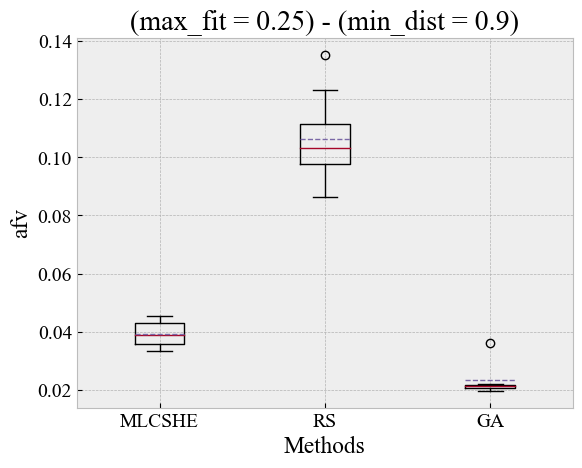

In [10]:
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
print(calculated_results_file_rq1)
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

for fit_thr, dist_thr, metric in product(FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS, ['dbs', 'afv']):
    draw_boxplot(
        data=processed_results_df_rq1,
        methods=['MLCSHE', 'RS', 'GA'],
        fit_thr=fit_thr,
        dist_thr=dist_thr,
        metric=metric,
        save_fig=True
    )

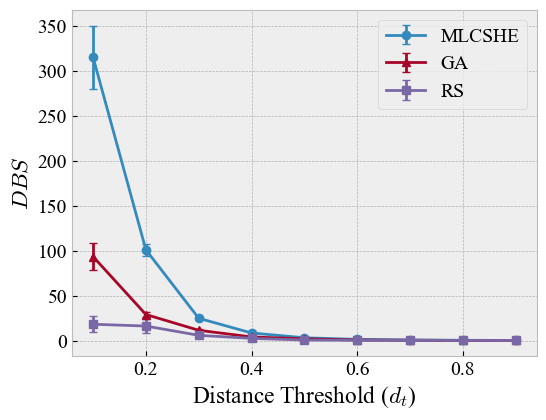

In [16]:
def draw_dbs_vs_dist_thr(data, fit_thr, save_fig=False, dest_folder: str = 'diagrams', methods=['MLCSHE', 'GA', 'RS'], markers=['o', '^', 's', 'd', '^', 'x', '*']):
    """Draw the DBS vs. distance threshold plot.
    Every point has a confidence interval.
    Each line represents a method.
    """
    assert fit_thr in FITNESS_THRESHOLDS, f'fit_thr must be {FITNESS_THRESHOLDS}'
    fig, ax = plt.subplots(figsize=(6, 4.5))
    for method, marker in zip(methods, markers):
        x = DISTANCE_THRESHOLDS
        # y = data[(data.method==method) & (data.fit_thr==fit_thr)]['dbs'].values[0]
        y_mean = data[(data.method==method) & (data.fit_thr==fit_thr)]['dbs_mean'].values
        y_std = data[(data.method==method) & (data.fit_thr==fit_thr)]['dbs_95_ci'].values
        ax.errorbar(x, y_mean, yerr=y_std, label=method, capsize=3, marker=marker)
    ax.set_xlabel('Distance Threshold ($d_t$)')
    ax.set_ylabel('$DBS$')
    # ax.set_title(f'DBS vs. Distance Threshold (Fitness Threshold={fit_thr})')
    ax.legend()
    if save_fig:
        dest_dir = RESULTS_DIR.joinpath(dest_folder)
        dest_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(dest_dir.joinpath(f'rq1_dbs_vs_dist_thr_fit_thr_{fit_thr}.png'), dpi=300)
        fig.savefig(dest_dir.joinpath(f'rq1_dbs_vs_dist_thr_fit_thr_{fit_thr}.pdf'))
    plt.show()

# Load the calculated results.
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

draw_dbs_vs_dist_thr(processed_results_df_rq1, 0.2, save_fig=True)

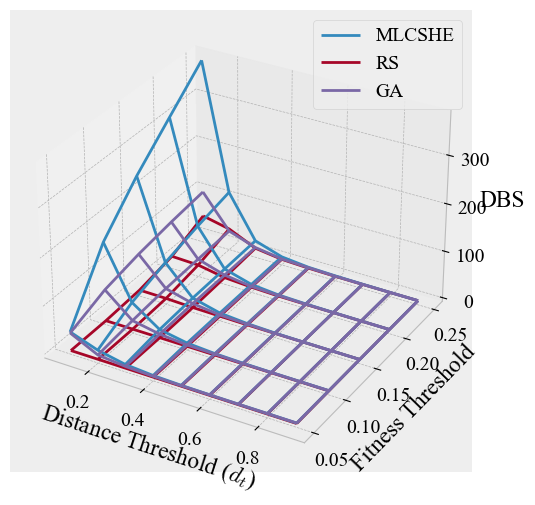

In [17]:
def plot_3d(data):
    """Plot the DBS vs. fitness threshold vs. distance threshold.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    for method in ['MLCSHE', 'RS', 'GA']:
    # for method in ['MLCSHE']:
        x = DISTANCE_THRESHOLDS
        y = FITNESS_THRESHOLDS
        x, y = np.meshgrid(x, y)
        z = np.zeros((len(FITNESS_THRESHOLDS), len(DISTANCE_THRESHOLDS)))
        for i in range(len(FITNESS_THRESHOLDS)):
            for j in range(len(DISTANCE_THRESHOLDS)):
                z[i, j] = data[(data.method==method) & (data.fit_thr==FITNESS_THRESHOLDS[i]) & (data.dist_thr==DISTANCE_THRESHOLDS[j])]['dbs_mean'].values[0]
        # surf = ax.plot_surface(x, y, z, label=method)
        # surf._facecolors2d=surf._facecolors3d
        # surf._edgecolors2d=surf._edgecolors3d
        ax.plot_wireframe(x, y, z, label=method, color=next(ax._get_lines.prop_cycler)['color'])
    ax.set_xlabel('Distance Threshold ($d_t$)')
    ax.set_ylabel('Fitness Threshold')
    ax.set_zlabel('DBS')
    ax.legend()
    plt.show()

# Load the calculated results.
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

plot_3d(processed_results_df_rq1)

## Generating the body of $\LaTeX$ tables

In [20]:
'''
Generate the body of the table for DBS and AFV based on procesed results.

Example:
\multirow{3}{2em}{$d_t=<dist_thr>$}&$<method>$&$<df[(df.method==method) & (df.dist_thr==<dist.thr>) & (df.fit_thr==<fit_thr>)][dbs_mean]>\pm <df[(df.method==method) & (df.dist_thr==<dist.thr>) & (df.fit_thr==<fit_thr>)][dbs_95_ci]>$&
$0.5\pm 0.4$&$5.1\pm 2.0$&$19.2\pm 9.0$&$-$&$0.096\pm 0.0$&$0.124\pm 0.006$&$0.159\pm 0.007$\\
    &$GA$&$1150\pm ?$&$1180\pm ?$&$1218\pm ?$&$1222\pm ?$&$0.034\pm ?$&$0.036\pm ?$&$0.038\pm ?$&$0.039\pm ?$\\
    &$MLSHE$&$65.9\pm 30.6$&$266.7\pm 54.9$&$382.8\pm 57.6$&$473.4\pm 59.3$&$0.044\pm 0.002$&$0.068\pm 0.004$&$0.085\pm 0.007$&$0.102\pm 0.010$\\
    \cmidrule(lr){1-6}\cmidrule(lr){7-10}
'''

def create_latex_table_rq1(data:pd.DataFrame, dist_thr:list, fit_thr:list):
    """Create a latex table for the DBS vs. distance threshold plot."""
    table = ''
    for d in dist_thr:
        table += f'\\multirow{{3}}{{2em}}{{$d_t={d}$}}'

        for method in ['RS', 'GA', 'MLCSHE']:
            table += f'&{method}'
            # DBS values
            for f in fit_thr:
                dbs_mean = data[(data.method==method) & (data.dist_thr==d) & (data.fit_thr==f)]['dbs_mean'].values[0]
                dbs_95_ci = data[(data.method==method) & (data.dist_thr==d) & (data.fit_thr==f)]['dbs_95_ci'].values[0]
                table += f'&${dbs_mean:.1f}\pm {dbs_95_ci:.1f}$'
            # # AFV values
            # for f in fit_thr:
            #     if method == 'RS' and f == 0.05:
            #         table += f'&$-$'
            #         continue
            #     afv_mean = data[(data.method==method) & (data.dist_thr==d) & (data.fit_thr==f)]['afv_mean'].values[0]
            #     afv_95_ci = data[(data.method==method) & (data.dist_thr==d) & (data.fit_thr==f)]['afv_95_ci'].values[0]
            #     table += f'&${afv_mean:.3f}\pm {afv_95_ci:.3f}$'
            table += '\\\\\n'
        # table += '\cmidrule(lr){1-6}\cmidrule(lr){7-10}\n'
        if d == dist_thr[-1]:
            table += '\\bottomrule'
        else:
            table += '\cmidrule(lr){1-2}\cmidrule(lr){3-6}\n'
    return table

# Load the calculated results.
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    processed_results_df_rq1 = pd.read_pickle(f)

# create_latex_table_rq1(processed_results_df_rq1, DISTANCE_THRESHOLDS, [0.05, 0.1, 0.15, 0.2])
print(create_latex_table_rq1(processed_results_df_rq1, DISTANCE_THRESHOLDS, [0.05, 0.1, 0.15, 0.2]))

\multirow{3}{2em}{$d_t=0.1$}&RS&$0.0\pm 0.0$&$0.5\pm 0.4$&$5.1\pm 2.0$&$19.0\pm 8.8$\\
&GA&$37.2\pm 8.9$&$66.7\pm 11.4$&$82.8\pm 10.8$&$94.1\pm 15.4$\\
&MLCSHE&$39.6\pm 17.2$&$166.8\pm 33.2$&$247.5\pm 29.2$&$315.4\pm 35.1$\\
\cmidrule(lr){1-2}\cmidrule(lr){3-6}
\multirow{3}{2em}{$d_t=0.2$}&RS&$0.0\pm 0.0$&$0.5\pm 0.4$&$4.6\pm 1.5$&$17.0\pm 7.3$\\
&GA&$9.2\pm 2.5$&$18.8\pm 3.3$&$26.0\pm 2.6$&$29.8\pm 2.8$\\
&MLCSHE&$19.4\pm 6.8$&$57.5\pm 6.7$&$82.0\pm 5.2$&$101.6\pm 6.5$\\
\cmidrule(lr){1-2}\cmidrule(lr){3-6}
\multirow{3}{2em}{$d_t=0.3$}&RS&$0.0\pm 0.0$&$0.4\pm 0.3$&$2.6\pm 0.6$&$6.7\pm 2.1$\\
&GA&$3.7\pm 0.9$&$8.0\pm 1.0$&$11.2\pm 1.2$&$12.3\pm 1.1$\\
&MLCSHE&$7.9\pm 1.8$&$17.9\pm 1.1$&$23.1\pm 1.7$&$25.6\pm 2.2$\\
\cmidrule(lr){1-2}\cmidrule(lr){3-6}
\multirow{3}{2em}{$d_t=0.4$}&RS&$0.0\pm 0.0$&$0.4\pm 0.3$&$1.9\pm 0.4$&$3.3\pm 0.7$\\
&GA&$1.7\pm 0.4$&$3.1\pm 0.6$&$4.4\pm 0.4$&$4.9\pm 0.5$\\
&MLCSHE&$3.5\pm 0.8$&$7.4\pm 0.5$&$8.7\pm 1.0$&$9.3\pm 1.1$\\
\cmidrule(lr){1-2}\cmidrule(lr){

In [21]:
'''
Generate the body of the table for statistical tests of DBS and AFV values.

Example:
\multirow{3}{2em}{$d_t=0.1$}&$MLCSHE$&$RS$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    &$MLCSHE$&$GA$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    &$GA$&$RS$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    \cmidrule(lr){1-11}\cmidrule(lr){12-19}
    \multirow{3}{2em}{$d_t=0.2$}&$MLCSHE$&$RS$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    &$MLCSHE$&$GA$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    &$GA$&$RS$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$&$?$\\
    \cmidrule(lr){1-11}\cmidrule(lr){12-19}
'''

def create_latex_table_stats_rq1(data:pd.DataFrame, fitness_thresholds:list, dist_thresholds:list):
    """Create a latex table for the statistical tests of DBS and AFV values."""
    table = '\midrule\n'
    for d in dist_thresholds:
        table += f'\\multirow{{3}}{{2em}}{{$d_t={d}$}}'
        for a, b in combinations(['MLCSHE', 'RS', 'GA'], 2):
            table += f'&${a}$&${b}$'
            # DBS values
            for f in fitness_thresholds:
                dbs_p_value = data[(data.A==a) & (data.B==b) & (data.dist_thr==d) & (data.fit_thr==f)]['dbs_p_value'].values[0]
                dbs_cles = data[(data.A==a) & (data.B==b) & (data.dist_thr==d) & (data.fit_thr==f)]['dbs_cles'].values[0]
                if np.isnan(dbs_p_value) or np.isnan(dbs_cles):
                    table += f'&$-$&$-$'
                else:
                    table += f'&$\\num{{{dbs_p_value:.2e}}}$&${dbs_cles:.2f}$'
            # # AFV values
            # for f in fitness_thresholds:
            #     afv_p_value = data[(data.A==a) & (data.B==b) & (data.dist_thr==d) & (data.fit_thr==f)]['afv_p_value'].values[0]
            #     afv_cles = data[(data.A==a) & (data.B==b) & (data.dist_thr==d) & (data.fit_thr==f)]['afv_cles'].values[0]
            #     if np.isnan(afv_p_value) or np.isnan(afv_cles):
            #         table += f'&$-$&$-$'
            #     else:
            #         table += f'&$\\num{{{afv_p_value:.2e}}}$&${afv_cles:.2f}$'
            table += '\\\\\n'
        if d == dist_thresholds[-1]:
            table += '\\bottomrule'
        else:
            # table += '\cmidrule(lr){1-11}\cmidrule(lr){12-19}\n'
            table += '\cmidrule(lr){1-3}\cmidrule(lr){4-11}\n'
    return table

# Load the statistical tests results.
statistical_tests_file_rq1 = RESULTS_DIR.joinpath('stat_tested_results_rq1.pkl')
with open(statistical_tests_file_rq1, 'rb') as f:
    statistical_tests_results_rq1 = pd.read_pickle(f)

t = create_latex_table_stats_rq1(statistical_tests_results_rq1, [0.05, 0.1, 0.15, 0.2], DISTANCE_THRESHOLDS)
print(t)

\midrule
\multirow{3}{2em}{$d_t=0.1$}&$MLCSHE$&$RS$&$-$&$-$&$\num{1.46e-04}$&$1.00$&$\num{1.78e-04}$&$1.00$&$\num{1.83e-04}$&$1.00$\\
&$MLCSHE$&$GA$&$\num{1.00e+00}$&$0.51$&$\num{4.40e-04}$&$0.97$&$\num{1.83e-04}$&$1.00$&$\num{1.83e-04}$&$1.00$\\
&$RS$&$GA$&$-$&$-$&$\num{1.46e-04}$&$0.00$&$\num{1.78e-04}$&$0.00$&$\num{1.83e-04}$&$0.00$\\
\cmidrule(lr){1-3}\cmidrule(lr){4-11}
\multirow{3}{2em}{$d_t=0.2$}&$MLCSHE$&$RS$&$-$&$-$&$\num{1.44e-04}$&$1.00$&$\num{1.73e-04}$&$1.00$&$\num{1.77e-04}$&$1.00$\\
&$MLCSHE$&$GA$&$\num{4.88e-02}$&$0.77$&$\num{1.79e-04}$&$1.00$&$\num{1.81e-04}$&$1.00$&$\num{1.73e-04}$&$1.00$\\
&$RS$&$GA$&$-$&$-$&$\num{1.44e-04}$&$0.00$&$\num{1.73e-04}$&$0.00$&$\num{6.32e-03}$&$0.14$\\
\cmidrule(lr){1-3}\cmidrule(lr){4-11}
\multirow{3}{2em}{$d_t=0.3$}&$MLCSHE$&$RS$&$-$&$-$&$\num{1.38e-04}$&$1.00$&$\num{1.63e-04}$&$1.00$&$\num{1.70e-04}$&$1.00$\\
&$MLCSHE$&$GA$&$\num{3.35e-03}$&$0.89$&$\num{1.74e-04}$&$1.00$&$\num{1.72e-04}$&$1.00$&$\num{1.75e-04}$&$1.00$\\
&$RS$&$GA$&$-$&

# RQ2: Efficiency

## Load and Process Data

__NOTE: in case raw data has changed, first load the new input files and update the raw results using the [Read Input Files section](#read-input-files) in RQ1__

### Process Raw Data & Calculate Metrics

In [2]:
import math


def divide_results_into_intervals(results: dict, intervals: int = 10) -> dict:
    """Returns a dictionary with the results divided into intervals.
    The format of the returned dictionary is as follows:\n
    {
        'interval_1': {
            'run_1': [fitness_values],
            'run_2': [fitness_values],
            ...
        },
        ...
    }
    """
    divided_results = {f'interval_{i}': {} for i in range(1, intervals + 1)}
    for run, cs_archive in results.items():
        interval_step = len(cs_archive) / intervals 
        for i in range(1, intervals+1):
            divided_results[f'interval_{i}'][run] = cs_archive[:math.floor(i * interval_step)]
    return divided_results

def remove_similar(cs_archive: list, min_distance: float=0.0) -> list:
    """Remove similar complete solutions from `cs_archive` based on
    their pairwise distance.
    """
    # Compute pairwise distance between all complete solutions solutions.
    pdist = PairwiseDistance(
        cs_archive, cfg.numeric_ranges, cfg.categorical_indices)

    # If a member of the cs_archive is not similar to any other member in the cs_archive_distinct
    # list, then add it to the cs_archive_distinct list.
    cs_archive_distinct = []
    if len(cs_archive) > 1:
        for cs in cs_archive:
            if not any([pdist.get_distance(cs, cs_distinct) < min_distance for cs_distinct in cs_archive_distinct]):
                cs_archive_distinct.append(cs)
    else:
        cs_archive_distinct = cs_archive
    

    return cs_archive_distinct


def sort_trim(cs_archive: list, max_fitness: float) -> list:
    """Sort and trim the `cs_archive` based on the `max_fitness` value.
    """
    # Sort the cs_archive from low to high fitness.
    cs_archive_sorted = sorted(
        cs_archive, key=lambda x: x.fitness.values[0])

    # Trim the cs archive
    for cs in cs_archive_sorted:
        if cs.fitness.values[0] >= max_fitness:
            cs_archive_trimmed = cs_archive_sorted[:cs_archive_sorted.index(
                cs)]
            break

    return cs_archive_trimmed

def process_results(results: dict, max_fitness: float = 1.0, min_distance: float = 0.0, verbose: bool = False) -> dict:
    """Gets a `results` dict and returns a list of distinct
    complete solutions that have fitness values higher than
    `max_fitness` and pairwise distance higher than `min_distance`.
    """
    distinct_trimmed_fitness_dict = {}
    for run_number, cs_archive in results.items():
        # Sort and trim the cs_archive based on the `max_fitness` value.
        boundaries = sort_trim(cs_archive, max_fitness)
        # Remove similar complete solutions from `cs_archive` based on `min_distance`.
        distinct_boundaries = remove_similar(boundaries, min_distance)

        if verbose:
            print(f'len(cs_archive) = {len(cs_archive)}')
            print(f'len(boundaries) = {len(boundaries)}')
            print(f'propotion = {len(boundaries) / len(cs_archive)}')
            print(f'len(distinct_boundaries) = {len(distinct_boundaries)}')

        distinct_trimmed_fitness_dict[run_number] = [cs.fitness.values[0]
                                                     for cs in distinct_boundaries]

    return distinct_trimmed_fitness_dict

In [3]:
# Load the raw results from a file.
raw_results_file = RESULTS_DIR.joinpath('raw_results.pkl')
with open(raw_results_file, 'rb') as f:
    raw_results_dict = pickle.load(f)

raw_results_dict

divided_raw_results_dict = {method: divide_results_into_intervals(raw_results_dict[method], intervals=NUM_INTERVALS) for method in raw_results_dict.keys()}

processed_results_df_rq2 = pd.DataFrame()
# process the results
for method, divided_results in divided_raw_results_dict.items():
    for interval, mf, mb in product(list(divided_results.keys()), FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS):
        processed_results_df_rq2 = pd.concat([processed_results_df_rq2, pd.DataFrame([{'method': method, 'fit_thr':mf, 'dist_thr':mb, 'interval': int(interval.split('_')[-1]), 'results':process_results(divided_results[interval], max_fitness=mf, min_distance=mb), 'n_runs':len(divided_results[interval])}])])
        processed_results_df_rq2.reset_index(drop=True, inplace=True)
        print(f'{method} {interval} {mf} {mb} done!')

# Save the processed results to a file.
processed_results_file_rq2 = RESULTS_DIR.joinpath('processed_results_rq2.pkl')
with open(processed_results_file_rq2, 'wb') as f:
    pd.to_pickle(processed_results_df_rq2, f)

MLCSHE interval_1 0.05 0.1 done!
MLCSHE interval_1 0.05 0.2 done!
MLCSHE interval_1 0.05 0.3 done!
MLCSHE interval_1 0.05 0.4 done!
MLCSHE interval_1 0.05 0.5 done!
MLCSHE interval_1 0.05 0.6 done!
MLCSHE interval_1 0.05 0.7 done!
MLCSHE interval_1 0.05 0.8 done!
MLCSHE interval_1 0.05 0.9 done!
MLCSHE interval_1 0.1 0.1 done!
MLCSHE interval_1 0.1 0.2 done!
MLCSHE interval_1 0.1 0.3 done!
MLCSHE interval_1 0.1 0.4 done!
MLCSHE interval_1 0.1 0.5 done!
MLCSHE interval_1 0.1 0.6 done!
MLCSHE interval_1 0.1 0.7 done!
MLCSHE interval_1 0.1 0.8 done!
MLCSHE interval_1 0.1 0.9 done!
MLCSHE interval_1 0.15 0.1 done!
MLCSHE interval_1 0.15 0.2 done!
MLCSHE interval_1 0.15 0.3 done!
MLCSHE interval_1 0.15 0.4 done!
MLCSHE interval_1 0.15 0.5 done!
MLCSHE interval_1 0.15 0.6 done!
MLCSHE interval_1 0.15 0.7 done!
MLCSHE interval_1 0.15 0.8 done!
MLCSHE interval_1 0.15 0.9 done!
MLCSHE interval_1 0.2 0.1 done!
MLCSHE interval_1 0.2 0.2 done!
MLCSHE interval_1 0.2 0.3 done!
MLCSHE interval_1 0.2 

In [4]:
#  Load the processed results from a file.
processed_results_file_rq2 = RESULTS_DIR.joinpath('processed_results_rq2.pkl')
with open(processed_results_file_rq2, 'rb') as f:
    processed_results_df_rq2 = pd.read_pickle(f)

processed_results_df_rq2

,method,fit_thr,dist_thr,interval,results,n_runs
0,MLCSHE,0.05,0.1,1,"{'run_1': [], 'run_2': [0.03507924906667169, 0...",10
1,MLCSHE,0.05,0.2,1,"{'run_1': [], 'run_2': [0.03507924906667169, 0...",10
2,MLCSHE,0.05,0.3,1,"{'run_1': [], 'run_2': [0.03507924906667169], ...",10
3,MLCSHE,0.05,0.4,1,"{'run_1': [], 'run_2': [0.03507924906667169], ...",10
4,MLCSHE,0.05,0.5,1,"{'run_1': [], 'run_2': [0.03507924906667169], ...",10
...,...,...,...,...,...,...
1345,GA,0.25,0.5,10,"{'run_1': [0.02085925568387677, 0.092971252397...",10
1346,GA,0.25,0.6,10,"{'run_1': [0.02085925568387677], 'run_2': [0.0...",10
1347,GA,0.25,0.7,10,"{'run_1': [0.02085925568387677], 'run_2': [0.0...",10
1348,GA,0.25,0.8,10,"{'run_1': [0.02085925568387677], 'run_2': [0.0...",10


In [5]:
# Load processed_results_df_rq2
processed_results_file_rq2 = RESULTS_DIR.joinpath('processed_results_rq2.pkl')
with open(processed_results_file_rq2, 'rb') as f:
    processed_results_df_rq2 = pd.read_pickle(f)

def calculate_dbs(data: dict):
    return [len(fitness_values) for fitness_values in list(data.values())]

def calculate_afv(data: dict):
    # return [np.mean(fitness_values) if np.mean(fitness_values) > 0 else 0.0 for fitness_values in list(data.values())]
    return [np.mean(fitness_values) for fitness_values in list(data.values())]

# Calculate and add DBS and AFV values to the processed_results_df_rq2
processed_results_df_rq2['dbs'] = processed_results_df_rq2['results'].apply(lambda x: calculate_dbs(x))
processed_results_df_rq2['dbs_mean'] = processed_results_df_rq2['dbs'].apply(lambda x: np.mean(x))
processed_results_df_rq2['dbs_std'] = processed_results_df_rq2['dbs'].apply(lambda x: np.std(x))
processed_results_df_rq2['dbs_95_ci'] = 1.96 * processed_results_df_rq2['dbs_std'] / np.sqrt(processed_results_df_rq2['n_runs'])
processed_results_df_rq2['afv'] = processed_results_df_rq2['results'].apply(lambda x: calculate_afv(x))
processed_results_df_rq2['afv_mean'] = processed_results_df_rq2['afv'].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan)
processed_results_df_rq2['afv_std'] = processed_results_df_rq2['afv'].apply(lambda x: np.std(x))
processed_results_df_rq2['afv_95_ci'] = 1.96 * processed_results_df_rq2['afv_std'] / np.sqrt(processed_results_df_rq2['n_runs'])
# change Nan values to 0
processed_results_df_rq2.fillna(0, inplace=True)

# Save the processed results to a file.
calculated_results_file_rq2 = RESULTS_DIR.joinpath('calculated_results_rq2.pkl')
with open(calculated_results_file_rq2, 'wb') as f:
    pd.to_pickle(processed_results_df_rq2, f)

c:\Users\sepeh\Projects\MLCSHE\venv1\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sepeh\AppData\Local\Temp\ipykernel_15996\3912386901.py:19: RuntimeWarning: Mean of empty slice
  processed_results_df_rq2['afv_mean'] = processed_results_df_rq2['afv'].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan)


In [6]:
# Compare whether the divided results at the last interval match the rq1 results.

# Load calculated_results_df_rq2
calculated_results_file_rq2 = RESULTS_DIR.joinpath('calculated_results_rq2.pkl')
with open(calculated_results_file_rq2, 'rb') as f:
    calculated_results_df_rq2 = pd.read_pickle(f)

# Load calcualted_results_df_rq1
calculated_results_file_rq1 = RESULTS_DIR.joinpath('calculated_results_rq1.pkl')
with open(calculated_results_file_rq1, 'rb') as f:
    calculated_results_df_rq1 = pd.read_pickle(f)

# calculated_results_df_rq2[(calculated_results_df_rq2.method=='GA') & (calculated_results_df_rq2.fit_thr==0.20) & (calculated_results_df_rq2.dist_thr==0.3)].reindex(columns=['method', 'interval', 'fit_thr', 'dist_thr', 'dbs_mean', 'dbs_95_ci', 'afv_mean', 'afv_95_ci'])
# calculated_results_df_rq2[calculated_results_df_rq2.method=='GA'].reindex(columns=['method', 'interval', 'fit_thr', 'dist_thr', 'dbs_mean', 'dbs_95_ci', 'afv_mean', 'afv_95_ci'])
# calculated_results_df_rq2
# calculated_results_df_rq1[(calculated_results_df_rq1.method=='GA') & (calculated_results_df_rq1.fit_thr==0.20) & (calculated_results_df_rq1.dist_thr==0.3)].reindex(columns=['method', 'interval', 'fit_thr', 'dist_thr', 'dbs_mean', 'dbs_95_ci', 'afv_mean', 'afv_95_ci'])


counter = 0
highest_diff = 0
for method, mf, md in product(['MLCSHE', 'GA', 'RS'], FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS):
    rq1_result = calculated_results_df_rq1[(calculated_results_df_rq1.method==method) & (calculated_results_df_rq1.fit_thr==mf) & (calculated_results_df_rq1.dist_thr==md)]['dbs_mean'].values[0]
    rq2_result = calculated_results_df_rq2[(calculated_results_df_rq2.method==method) & (calculated_results_df_rq2.interval==10) & (calculated_results_df_rq2.fit_thr==mf) & (calculated_results_df_rq2.dist_thr==md)]['dbs_mean'].values[0]
    if abs(rq1_result - rq2_result) > 1:
        counter += 1
        print(f'counter:{counter}, method: {method}, fit_thr: {mf}, dist_thr: {md}, rq1_result: {rq1_result}, rq2_result: {rq2_result}, diff: {abs(rq1_result - rq2_result)}')
        if abs(rq1_result - rq2_result) > highest_diff:
            highest_diff = abs(rq1_result - rq2_result)
print(f'highest_diff: {highest_diff}')

highest_diff: 0


## Statistical Tests of $DBS$ and $AFV$ Values

In [7]:
calculated_results_file_rq2 = RESULTS_DIR.joinpath('calculated_results_rq2.pkl')
print(calculated_results_file_rq2)
with open(calculated_results_file_rq2, 'rb') as f:
    processed_results_df_rq2 = pd.read_pickle(f)

rq2_stat_test_df = pd.DataFrame(columns=['interval', 'fit_thr', 'dist_thr', 'A', 'B', 'dbs_p_value', 'dbs_cles', 'afv_p_value', 'afv_cles'])
for interval, fit_thr, dist_thr in product(list(range(1, NUM_INTERVALS+1)), FITNESS_THRESHOLDS, DISTANCE_THRESHOLDS):
    for a, b in combinations(['MLCSHE', 'RS', 'GA'], 2):
        x_dbs = processed_results_df_rq2[(processed_results_df_rq2.method==a) & (processed_results_df_rq2.interval==interval) & (processed_results_df_rq2.fit_thr==fit_thr) & (processed_results_df_rq2.dist_thr==dist_thr)]['dbs'].values[0]
        y_dbs = processed_results_df_rq2[(processed_results_df_rq2.method==b) & (processed_results_df_rq2.interval==interval) & (processed_results_df_rq2.fit_thr==fit_thr) & (processed_results_df_rq2.dist_thr==dist_thr)]['dbs'].values[0]
        x_afv = processed_results_df_rq2[(processed_results_df_rq2.method==a) & (processed_results_df_rq2.interval==interval) & (processed_results_df_rq2.fit_thr==fit_thr) & (processed_results_df_rq2.dist_thr==dist_thr)]['afv'].values[0]
        y_afv = processed_results_df_rq2[(processed_results_df_rq2.method==b) & (processed_results_df_rq2.interval==interval) & (processed_results_df_rq2.fit_thr==fit_thr) & (processed_results_df_rq2.dist_thr==dist_thr)]['afv'].values[0]
        if len(x_dbs) == 0 or len(y_dbs) == 0 or max(x_dbs) == 0 or max(y_dbs) == 0:
            dbs_p_value = np.nan
            dbs_cles = np.nan
        else:
            dbs_df = pg.mwu(x_dbs, y_dbs, alternative='two-sided')
            dbs_p_value = dbs_df['p-val'].values[0]
            dbs_cles = dbs_df['CLES'].values[0]
        
        # If any value in x_afv or y_afv is nan, then the p-value is nan
        if np.isnan(x_afv).any() or np.isnan(y_afv).any():
            afv_p_value = np.nan
            afv_cles = np.nan
        else:
            afv_df = pg.mwu(x_afv, y_afv, alternative='two-sided')
            afv_p_value = afv_df['p-val'].values[0]
            afv_cles = afv_df['CLES'].values[0]
        
        rq2_stat_test_df = pd.concat([rq2_stat_test_df, pd.DataFrame([{
            'interval':interval,
            'fit_thr':fit_thr,
            'dist_thr':dist_thr,
            'A':a,
            'B':b,
            'dbs_p_value':dbs_p_value,
            'dbs_cles':dbs_cles,
            'afv_p_value':afv_p_value,
            'afv_cles':afv_cles
            }])])

rq2_stat_test_df.reset_index(drop=True, inplace=True)

# Save the results.
rq2_stat_test_file = RESULTS_DIR.joinpath('stat_tested_results_rq2.pkl')
with open(rq2_stat_test_file, 'wb') as f:
    rq2_stat_test_df.to_pickle(f)

c:\Users\sepeh\Projects\MLCSHE\results\postprocess\calculated_results_rq2.pkl


In [8]:
#  Load the results.
rq2_stat_test_file = RESULTS_DIR.joinpath('stat_tested_results_rq2.pkl')
with open(rq2_stat_test_file, 'rb') as f:
    rq2_stat_test_df = pd.read_pickle(f)

rq2_stat_test_df

,interval,fit_thr,dist_thr,A,B,dbs_p_value,dbs_cles,afv_p_value,afv_cles
0,1,0.05,0.1,MLCSHE,RS,NaN,NaN,NaN,NaN
1,1,0.05,0.1,MLCSHE,GA,0.007847,0.155,NaN,NaN
2,1,0.05,0.1,RS,GA,NaN,NaN,NaN,NaN
3,1,0.05,0.2,MLCSHE,RS,NaN,NaN,NaN,NaN
4,1,0.05,0.2,MLCSHE,GA,0.005337,0.140,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1345,10,0.25,0.8,MLCSHE,GA,0.582778,0.550,0.005795,0.87
1346,10,0.25,0.8,RS,GA,0.368120,0.450,0.002202,0.91
1347,10,0.25,0.9,MLCSHE,RS,1.000000,0.500,0.000183,0.00
1348,10,0.25,0.9,MLCSHE,GA,1.000000,0.500,0.000440,0.97


## Drawing Plots

c:\Users\sepeh\Projects\MLCSHE\results\postprocess\calculated_results_rq2.pkl


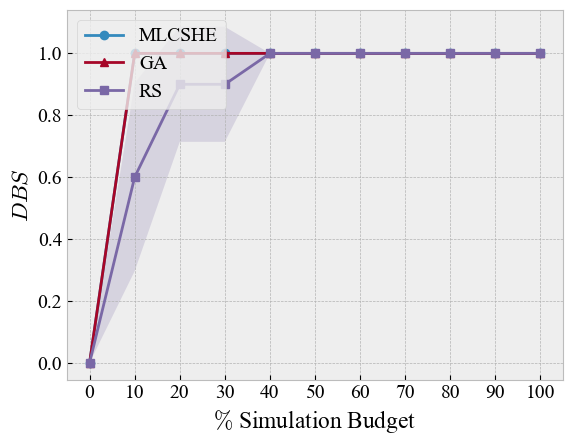

In [30]:
# Draw progression plot for metrics given a method, fitness threshold, and distance threshold
def draw_progression_plot(data:pd.DataFrame, methods:list, fit_thr:float, dist_thr:float, metric:str, save_fig:bool = False , dest_folder: str = 'diagrams', markers=['o', '^', 's', 'd', '^', 'x', '*']):
    """Get the list of metric values for different methods, a given fitness threshold,
    and given distance threshold and draw a progression plot for them.
    The progression plot is a line plot where the x-axis is the number
    of intervals and the y-axis is the metric value.
    The progresion plot fills the area around the line plot with the standard deviation."""
    assert metric in ['dbs', 'afv'], 'metric must be either dbs or afv'
    assert len(methods) > 0, 'methods must be a non-empty list'
    assert fit_thr in FITNESS_THRESHOLDS, f'fit_thr must be {FITNESS_THRESHOLDS}'
    assert dist_thr in DISTANCE_THRESHOLDS, f'dist_thr must be {DISTANCE_THRESHOLDS}'

    fig = plt.figure(num=1, clear=True)
    ax = fig.add_subplot()
    xticks_step = 100 / NUM_INTERVALS
    # xticks = np.arange(xticks_step, 100 + xticks_step, xticks_step)
    xticks = np.arange(0, 100 + xticks_step, xticks_step)
    xticks = np.array(xticks, dtype=int)
    for method, marker in zip(methods, markers):
        values_per_method = data[(data.method == method) & (data.fit_thr == fit_thr) & (data.dist_thr == dist_thr)][f'{metric}_mean']
        values_per_method = [0.0] + [item for item in values_per_method]
        std_per_method = data[(data.method == method) & (data.fit_thr == fit_thr) & (data.dist_thr == dist_thr)][f'{metric}_95_ci']
        std_per_method = [0.0] + [item for item in std_per_method]
        ax.plot(xticks, values_per_method, label=method, marker=marker)
        ax.fill_between(xticks, np.array(values_per_method) - np.array(std_per_method), np.array(values_per_method) + np.array(std_per_method), alpha=0.2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_ylabel(f'${metric.upper()}$')
    ax.set_xlabel('$\%$ Simulation Budget')
    # ax.set_title(f'(max_fit = {fit_thr}) - (min_dist = {dist_thr})')
    ax.legend(loc='upper left')
    if save_fig:
        dest_dir = RESULTS_DIR.joinpath(dest_folder)
        dest_dir.mkdir(parents=True, exist_ok=True)
        # save png
        fig.savefig(dest_dir.joinpath(f'progression_plot_{metric}_max_fit_{fit_thr}_min_dist_{dist_thr}.png'), dpi=300)
        # save pdf
        fig.savefig(dest_dir.joinpath(f'progression_plot_{metric}_max_fit_{fit_thr}_min_dist_{dist_thr}.pdf'))


# load the calculated results
calculated_results_file_rq2 = RESULTS_DIR.joinpath('calculated_results_rq2.pkl')
print(calculated_results_file_rq2)
with open(calculated_results_file_rq2, 'rb') as f:
    calculated_results_df_rq2 = pd.read_pickle(f)

# Draw progression plot for dbs at different fitness thresholds and distance thresholds
for metric in ['dbs']:
    for fit_thr, dist_thr in product([0.15], DISTANCE_THRESHOLDS):
        draw_progression_plot(
            data=calculated_results_df_rq2,
            methods=['MLCSHE', 'GA', 'RS'],
            fit_thr=fit_thr,
            dist_thr=dist_thr,
            metric=metric,
            save_fig=True
        )

c:\Users\sepeh\Projects\MLCSHE\results\postprocess\calculated_results_rq2.pkl


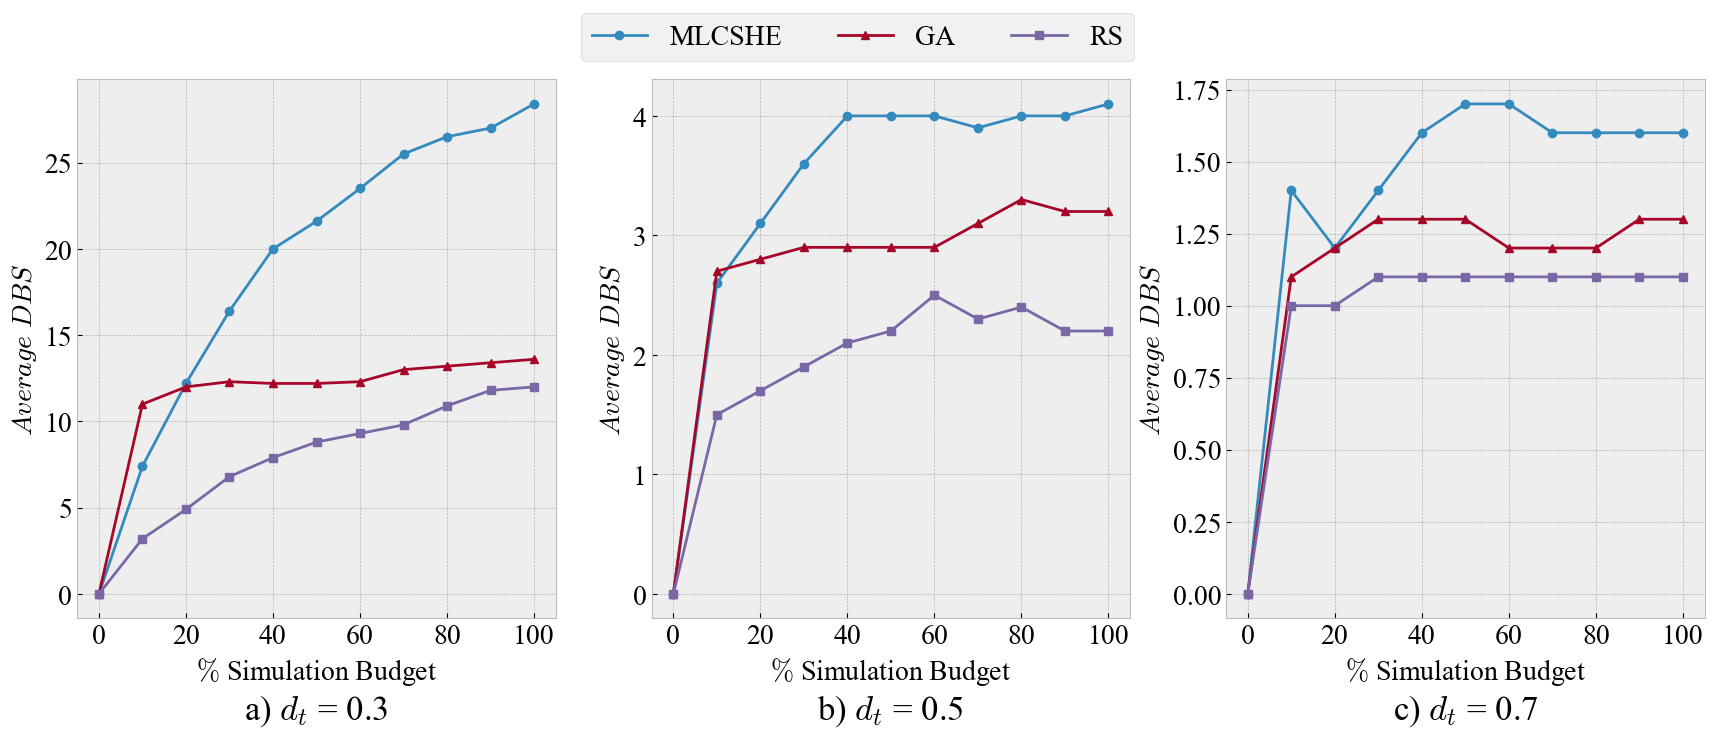

In [9]:
import string
plt.rcParams.update({'font.size': 20})
# Draw progression plot for metrics given a method, fitness threshold, and distance threshold
def draw_3_progression_plots(data:pd.DataFrame, methods:list, fit_thr:float, dist_thr:list, metric:str, save_fig:bool = False , dest_folder: str = 'diagrams', markers=['o', '^', 's', 'd', '^', 'x', '*']):
    """Get the list of metric values for different methods, a given fitness threshold,
    and given distance threshold and draw a progression plot for them.
    The progression plot is a line plot where the x-axis is the number
    of intervals and the y-axis is the metric value.
    The progresion plot fills the area around the line plot with the standard deviation."""
    assert metric in ['dbs', 'afv'], 'metric must be either dbs or afv'
    assert len(methods) > 0, 'methods must be a non-empty list'
    assert fit_thr in FITNESS_THRESHOLDS, f'fit_thr must be {FITNESS_THRESHOLDS}'

    fig = plt.figure(num=1, clear=True, figsize=(21, 7))
    xticks_step = 100 / NUM_INTERVALS
    # xticks = np.arange(xticks_step, 100 + xticks_step, xticks_step)
    x_values = np.arange(0, 100 + xticks_step, xticks_step)
    x_values = np.array(x_values, dtype=int)
    for i, dist in enumerate(dist_thr):
        # ax = fig.add_subplot(1, 3, i + 1, sharey=ax if i > 0 else None)
        ax = fig.add_subplot(1, 3, i + 1)
        for method, marker in zip(methods, markers):
            values_per_method = data[(data.method == method) & (data.fit_thr == fit_thr) & (data.dist_thr == dist)][f'{metric}_mean']
            values_per_method = [0.0] + [item for item in values_per_method]
            std_per_method = data[(data.method == method) & (data.fit_thr == fit_thr) & (data.dist_thr == dist)][f'{metric}_95_ci']
            std_per_method = [0.0] + [item for item in std_per_method]
            ax.plot(x_values, values_per_method, label=method, marker=marker)
            # ax.fill_between(xticks, np.array(values_per_method) - np.array(std_per_method), np.array(values_per_method) + np.array(std_per_method), alpha=0.2)
        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticks)
        ax.set_ylabel(f'$Average~{metric.upper()}$', fontsize=20)
        ax.set_xlabel('$\%$ Simulation Budget', fontsize=20)
        # ax.set_title(f'$d_t$ = {dist}', fontsize=20)
        ax.text(0.5, -0.17, f'{string.ascii_lowercase[i]}) $d_t$ = {dist}', fontsize=25, transform=ax.transAxes, ha='center', va='center')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(methods), fontsize=20)
    if save_fig:
        dest_dir = RESULTS_DIR.joinpath(dest_folder)
        dest_dir.mkdir(parents=True, exist_ok=True)
        # save png
        fig.savefig(dest_dir.joinpath(f'3_progression_plots_{metric}_max_fit_{fit_thr}.png'), dpi=300, bbox_inches='tight')
        # save pdf
        fig.savefig(dest_dir.joinpath(f'3_progression_plots_{metric}_max_fit_{fit_thr}.pdf'), bbox_inches='tight')


# load the calculated results
calculated_results_file_rq2 = RESULTS_DIR.joinpath('calculated_results_rq2.pkl')
print(calculated_results_file_rq2)
with open(calculated_results_file_rq2, 'rb') as f:
    calculated_results_df_rq2 = pd.read_pickle(f)

# Draw progression plot for dbs at different fitness thresholds and distance thresholds
for metric in ['dbs']:
    for fit_thr in FITNESS_THRESHOLDS:
        draw_3_progression_plots(
            data=calculated_results_df_rq2,
            methods=['MLCSHE', 'GA', 'RS'],
            fit_thr=fit_thr,
            dist_thr= [0.3, 0.5, 0.7],
            metric=metric,
            save_fig=True
        )
    
plt.rcParams.update({'font.size': 14})